In [1]:
from sklearn.datasets import load_boston
import pandas as pd
import numpy as np

# ANN
import torch
from torch.utils.data import DataLoader, Dataset
import torch.nn.functional as F

# Loss
from sklearn.metrics import mean_squared_error

# plot
import matplotlib.pyplot as plt

In [2]:
# 데이터 불러오기
boston = load_boston()
df = pd.DataFrame(boston['data'], columns=boston['feature_names'])
df['target'] = boston['target']

X = df.drop('target', axis=1).to_numpy()
Y = df['target'].to_numpy()

# Min_max Normalization
X = (X - X.min())/(X.max() - X.min())
Y = (Y - Y.min())/(Y.max() - Y.min())

# 텐서 데이터로 변환 클래스
class TensorData(Dataset):
    def __init__(self, x_data, y_data):
        self.x_data = torch.FloatTensor(x_data)
        self.y_data = torch.FloatTensor(y_data)
        self.len = len(y_data)
    
    def __getitem__(self, index):
        return self.x_data[index], self.y_data[index]

    def __len__(self):
        return self.len

# train, test 데이터 나누기(5:5)
x_train, x_test = X[:int(len(X)*0.5), :], X[int(len(X)*0.5):, :]
y_train, y_test = Y[:int(len(Y)*0.5)], Y[int(len(Y)*0.5):]

# train,test 데이터 배치 형태로 구축
trainsets = TensorData(x_train, y_train)
train_loader = DataLoader(trainsets, batch_size=32, shuffle=True)

testsets = TensorData(x_test, y_test)
test_loader = DataLoader(testsets, batch_size=32)

In [3]:
# 모델링
class Regressor(torch.nn.Module):
    def __init__(self):
        super().__init__() # 모델 연산 정의
        self.fc1 = torch.nn.Linear(13, 50, bias=True) # 입력층(13) -> 은닉층(50)
        self.fc2 = torch.nn.Linear(50, 30, bias=True) # 은닉층(50) -> 은닉층(30)
        self.fc3 = torch.nn.Linear(30, 1, bias=True)  # 은닉층(30) -> 출력층(1)
        self.dropout = torch.nn.Dropout(0.2) # 20%의 비율로 랜덤하게 노드를 없앤다.

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = F.relu(self.fc3(x))
        return x

In [4]:
# 모델, 손실함수, 최적화 방법
model = Regressor()
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001, weight_decay=1e-7) # weight_decay는 L2 정규화에서 penalty 정도를 의미한다.

In [5]:
# 학습
loss_ = [] # 그래프를 그리기 위한 loss 저장용 리스트
n_batch = len(train_loader) # 배치 개수

for epoch in range(400):

    running_loss = 0.0

    for i, data in enumerate(train_loader):
        
        inputs, values = data

        optimizer.zero_grad() # 최적화 초기화

        outputs = model(inputs) # 모델에 데이터 입력후 예측값 산출
        loss = criterion(outputs, values) # 손실함수 계산
        loss.backward() # 손실 함수 기준으로 역전파 설정
        optimizer.step() # 역전파 진행후 가중치 업데이트

        running_loss += loss.item()
    
    loss_.append(running_loss / n_batch) #MSE(Mean Squared Error) 계산

print('Finished Training')

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:528: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:528: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Finished Training


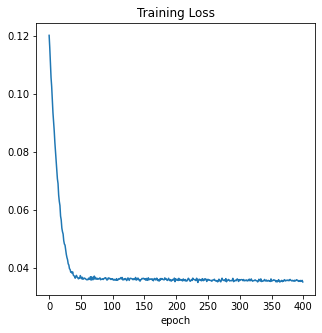

In [6]:
# loss 시각화
fig, ax = plt.subplots(figsize=(5,5))
ax.plot(loss_)
plt.title('Training Loss')
plt.xlabel('epoch')
plt.show()

In [7]:
# 모델 평가
def evaluation(dataloader):

    predictions = torch.tensor([], dtype= torch.float) # 예측값을 저장하는 텐서
    actual = torch.tensor([], dtype=torch.float) # 실제값을 저장하는 텐서

    with torch.no_grad():
        model.eval() # 평가를 할때는 .eval() 반드시 사용해야 한다.
        for data in dataloader:
            inputs, values = data
            outputs = model(inputs)
            predictions = torch.cat([predictions, outputs], dim=0) # cat을 통해 예측값을 누적
            actual = torch.cat([actual, values], dim=0) # cat을 통해 실제값을 누적
    
    predictions = predictions.numpy()
    actual = actual.numpy()
    rmse = np.sqrt(mean_squared_error(predictions, actual))

    return rmse

In [8]:
train_rmse = evaluation(train_loader) # 학습 데이터의 mse
test_rmse = evaluation(test_loader)

print("Train RMSE: ",train_rmse)
print("Test RMSE: ",test_rmse)

Train RMSE:  0.18466407
Test RMSE:  0.22723979
